In [1]:
import torch
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.optim as optim
from torchsummary import summary
import torch.optim.lr_scheduler as scheduler
from tqdm import trange, tqdm
import numpy as np
from torch.utils.data.sampler import BatchSampler
import matplotlib.pyplot as plt
from torchvision import models
from torch.optim import lr_scheduler
from collections import Counter
import math

In [2]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device('mps')
device

device(type='mps')

In [3]:
path = '/Users/charlie/ML/Charlie/Charlie-Data'

In [4]:
def get_mean_and_std(loader):
  mean = 0. 
  std = 0.
  count = 0
  pbar = tqdm(loader)
  for batch in pbar:
    images,_ = batch
    curr_count = images.size(0)
    images = images.view(curr_count, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    count += curr_count

  mean /= count
  std /= count
  return mean, std

In [5]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(1024),
    transforms.RandomHorizontalFlip(p = 0.25)
])
data = datasets.ImageFolder(root=path, transform=transforms_)
dataloader = DataLoader(data, batch_size=32)
# mean, std = get_mean_and_std(dataloader)

In [6]:
mean = [0.5108, 0.4802, 0.4441]
std = [0.2262, 0.2051, 0.1806]
print(mean, std)

[0.5108, 0.4802, 0.4441] [0.2262, 0.2051, 0.1806]


In [7]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(1024),
    transforms.RandomHorizontalFlip(p = 0.25),
    transforms.Normalize(mean=mean, std=std)
])
data = datasets.ImageFolder(root=path, transform=transforms_)
train, valid = random_split(data, [len(data) - 200, 200])

trainloader = DataLoader(train, batch_size=4, shuffle=True)
validloader = DataLoader(valid, batch_size=4, shuffle=True)

In [8]:
print(dict(Counter(data.targets)))

{0: 1190, 1: 948}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


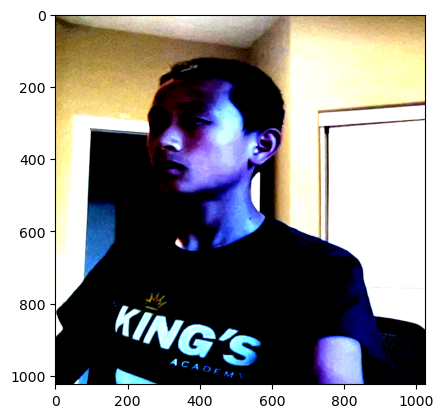

In [9]:
images, label = next(iter(trainloader))
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

In [10]:
model = models.resnet18(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = Adam(model.parameters(), lr=0.01)

# lambda1 = lambda epoch: epoch / 10
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda1)

/Users/charlie/.conda/envs/ML/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/charlie/.conda/envs/ML/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
summary(model.to('cpu'), (3, 1024, 1024))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 512, 512]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 512, 512]        128
├─ReLU: 1-3                              [-1, 64, 512, 512]        --
├─MaxPool2d: 1-4                         [-1, 64, 256, 256]        --
├─Sequential: 1-5                        [-1, 64, 256, 256]        --
|    └─BasicBlock: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-3                    [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 256, 256]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-6                    [-1, 64, 256, 256]        --
|    └─BasicBlock: 2-2                   [-1, 64, 256, 256]        --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 512, 512]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 512, 512]        128
├─ReLU: 1-3                              [-1, 64, 512, 512]        --
├─MaxPool2d: 1-4                         [-1, 64, 256, 256]        --
├─Sequential: 1-5                        [-1, 64, 256, 256]        --
|    └─BasicBlock: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-3                    [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 256, 256]        36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 256, 256]        128
|    |    └─ReLU: 3-6                    [-1, 64, 256, 256]        --
|    └─BasicBlock: 2-2                   [-1, 64, 256, 256]        --
|

In [12]:
max_accuracy = 0
model = model.to(device)
criterion = criterion.to(device)
for epoch in range(1):
    model.train()
    model_loss = 0
    pbar = tqdm(trainloader)
    for batch in pbar:
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)#
        loss = criterion(outputs, y)
        model_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()#
        optimizer.step()
    # scheduler.step()
    model_loss /= len(trainloader)
    model.eval()
    correct = 0
    incorrect = 0
    for batch in validloader:
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        outputs = model(X)
        _, preditced = torch.max(outputs.data, 1)
        correct += (preditced == y).float().sum()
        incorrect += (preditced != y).float().sum()
    print(f"Epoch: {epoch + 1} Accuracy: {correct / (correct + incorrect) * 100} Loss: {model_loss}")
    if max_accuracy <= correct / (correct + incorrect):
      max_accuracy = correct / (correct + incorrect)
      torch.save(model, 'model')
      print('Saved')
print(max_accuracy)

100%|██████████| 485/485 [09:17<00:00,  1.15s/it]


Epoch: 1 Accuracy: 97.5 Loss: 0.41597501928954067
Saved
tensor(0.9750, device='mps:0')


/Users/charlie/.conda/envs/ML/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [13]:
torch.save(model, 'model')

In [14]:
max_accuracy

tensor(0.9750, device='mps:0')

Without Freezing layers: Final_Accuracy = 97%

With Freezing layers: Final_Accuracy =  100%

SGD: 100%

ADAM: 98


Batch Size
4: 9min